In [1]:
import numpy   as np
import pandas  as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing   import scale, StandardScaler
from sklearn.decomposition   import PCA, TruncatedSVD

import pickle

---

### Function Definition

In [2]:
def catPred(kmObj, gTrue, pred): 
    '''
        kmObjn: a kmeans object
        gTrue: true categories (ground truth)
    '''
    fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(50,12))

    numClusters = kmObj.get_params()['n_clusters']
    
    for i in range(numClusters):
        mask = (pred == i)
        val = np.unique( gTrue[mask], return_counts=True)
        lbl = val[0]
        ht  = val[1] / val[1].sum()
        ax[i].bar(range(numClusters), height=ht, tick_label = lbl)
        ax[i].set_xticklabels(lbl, fontsize=20)
        ax[i].set_title(i, fontsize=20)

        ax[0].set_yticklabels(["0", "0.2", "0.4", "0.6", "0.8"], fontsize=20)
        ax[0].set_ylabel("Proportion", fontsize = 32);
        plt.suptitle("Proportion of Categories in each Clusterc", fontsize = 32);

In [3]:
def top_pred_words(kmObj, X_df, ftrs_list, pred, num_reviews=5, num_words=5): 
    '''
        kmObjn: a kmeans object
        gTrue: true categories (ground truth)
    '''
    
    numClusters = kmObj.get_params()['n_clusters']
    
    for i in range(numClusters):
        mask = (pred == i)
        
        rev_ind = [ind for ind, flag in enumerate(mask) if flag]
        
        sample_reviews = np.random.choice(rev_ind, num_reviews, replace=False)
        
        print("\nCluster ", i, " =====")
        for review in sample_reviews:
            indx = X_df[review,:].indices
            data = X_df[review,:].data
            
            termsVals = indx[data.argsort()][-num_words:]
            
            terms = []
            for w in termsVals:
                terms.append(ftrs_list[w])
            print(terms)

In [67]:
def center_top_words(kmeans_model, svd_model, ftrs, num_words=10):
    '''
        Print out the top num_words for each of the centroids in the kmeans model, 
        after we return the centroids back in 'word space' using the inverse SVD 
        transformation
        
        input:
        kmeans_model -  kmeans model object
        svd_model - svd model object
        ftrs - the features from the TFIDF vectorizer
        num_words - number of words to display        
    '''
        
    num_words += 1
    
    ftrs_array = np.array(ftrs)

    centroids = svd_model.inverse_transform(kmeans_model.cluster_centers_)

    for c in centroids:
        ind = np.abs(c).argsort()
        ind = ind[-1:-num_words:-1]
        print(ftrs_array[ind], "\n")

---

### Large Pickled Dataset



In [4]:
df = pd.read_pickle("fiveCats.pkl")

In [5]:
X_df = df.drop('category', axis=1)
y_df = df['category']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3)

In [7]:
print( X_train.shape, X_test.shape)

(517403, 11) (221745, 11)


---

### Manipulate data sets

In [8]:
m_termTrans = pickle.load(open('pkl_tfidf.p','rb'))
m_svd = pickle.load(open('pkl_svd.p','rb'))
m_kmeans = pickle.load(open('pkl_kmeans.p','rb'))

#### Vectorize Review Text

In [9]:
X_train_term  = m_termTrans.transform(X_train['text'])

In [10]:
X_train_term.shape

(517403, 153378)

In [11]:
ftrs = m_termTrans.get_feature_names()

#### Reduce Dimensionality

In [12]:
X_train_term_svd = m_svd.transform(X_train_term)

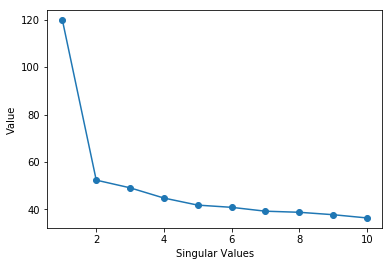

In [13]:
s = m_svd.singular_values_

x = [i+1 for i in range(len(s))]
plt.plot(x, s, marker='o')
plt.xlabel("Singular Values")
plt.ylabel("Value");

##### Percentage of Variance Explained

In [14]:
m_svd.explained_variance_ratio_.sum()*100

3.561945735071194

---

#### Cluster Reviews

In [15]:
X_test_term = m_termTrans.transform(X_test['text'])

In [17]:
X_test_term_svd = m_svd.transform(X_test_term)

In [18]:
X_test_term_svd.shape

(221745, 10)

In [19]:
pred = m_kmeans.predict(X_test_term_svd)

---

#### Visualize Clusters

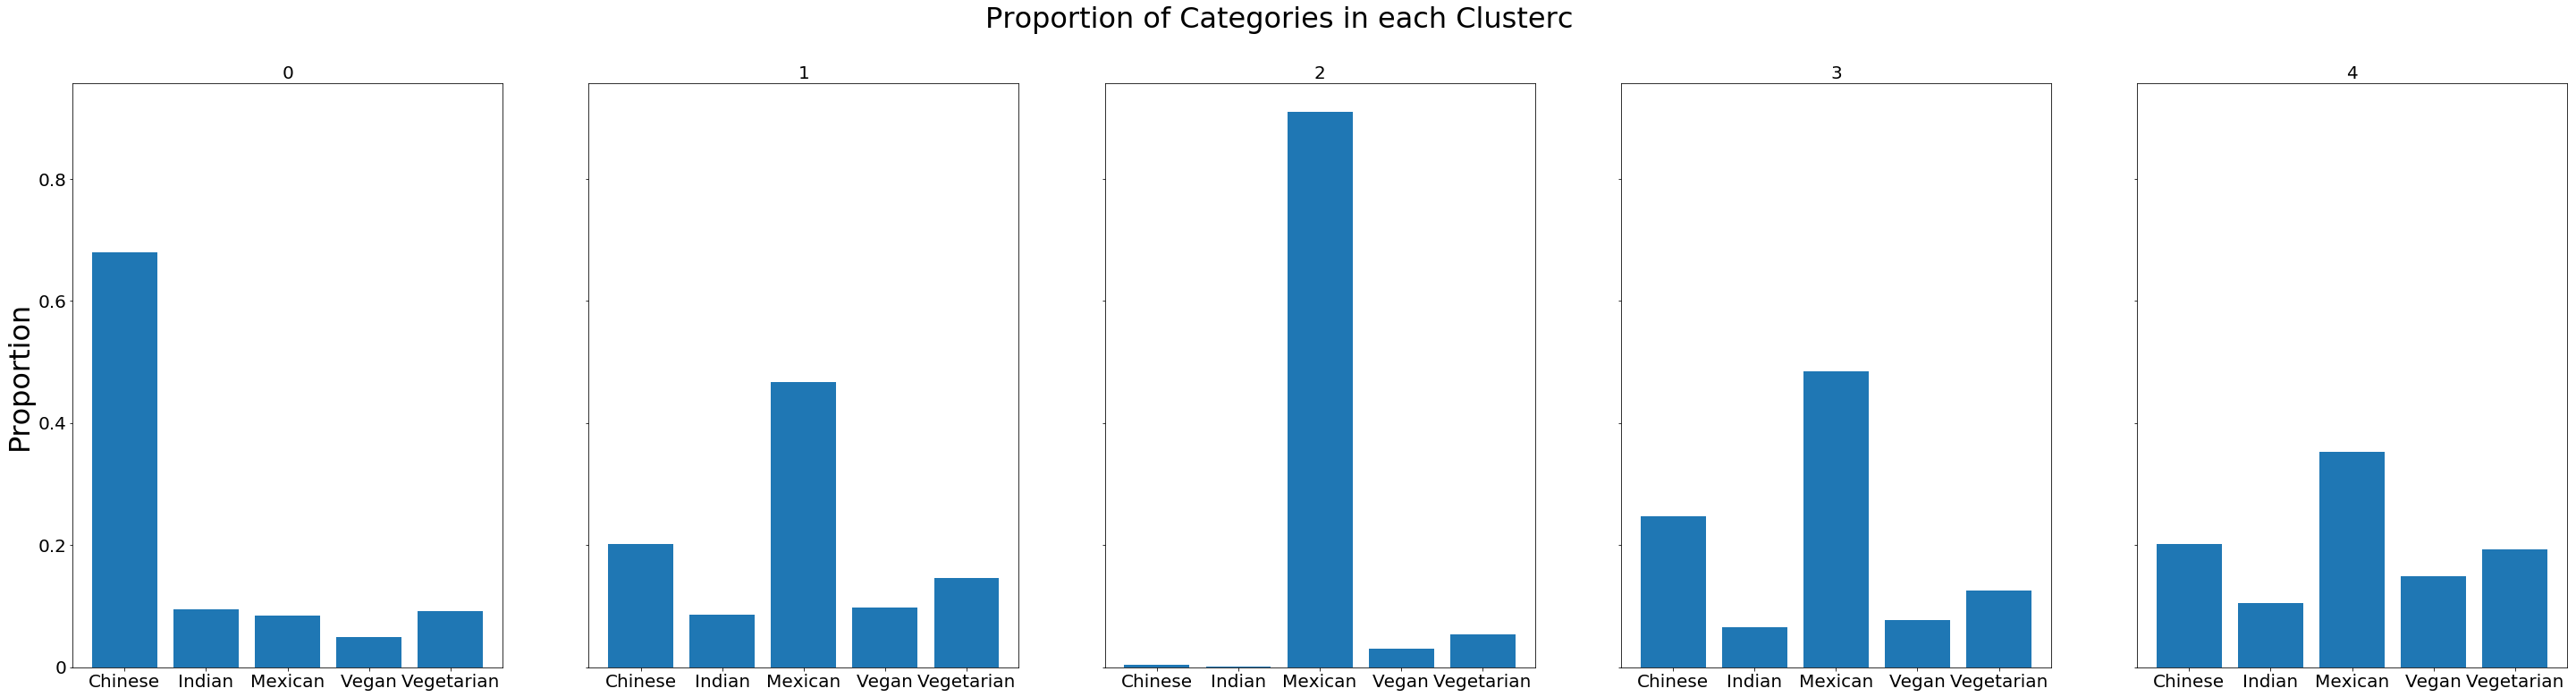

In [20]:
catPred(m_kmeans, y_test, pred)

In [21]:
top_pred_words(m_kmeans, X_test_term, ftrs, pred)


Cluster  0  =====
['rice', 'wasn', 'clean', 'cooked', 'properly']
['2nd', 'ohh', 'noodle', 'dumplings', 'yummmy']
['banging', 'scaring', 'roasty', 'noodle', 'dan']
['tso', 'buffet', 'sauce', 'sour', 'chicken']
['chickpeas', 'chicken', 'mimosa', 'unreasonable', 'himilayan']

Cluster  1  =====
['fine', 'establishment', 'treat', 'consistently', 'aurora']
['attend', 'hour', 'tenders', 'coronas', 'remote']
['gone', 'valley', 'quiet', 'diverse', 'rebirth']
['takeout', 'consistently', 'includes', 'kung', 'pao']
['rocks', 'night', 'burrito', 'nights', 'luxor']

Cluster  2  =====
['likes', 'lemonade', 'switched', 'musty', 'wonky']
['spicy', 'fridge', 'tacos', 'steelers', 'mushroom']
['good', 'babacoa', 'salsa', 'foo', 'enchiladas']
['chance', 'chips', 'tres', 'visit', 'guacamole']
['grab', 'limited', 'tacos', 'dives', 'overlook']

Cluster  3  =====
['family', 'decided', 'better', 'worse', 'plastic']
['counter', 'uptight', 'juggling', 'dreamin', 'cheeze']
['listen', 'location', 'turning', 'cost

#### Test Set: Class Balance

In [22]:
y_test.value_counts()

Mexican       90579
Chinese       59068
Vegetarian    31663
Vegan         22173
Indian        18262
Name: category, dtype: int64

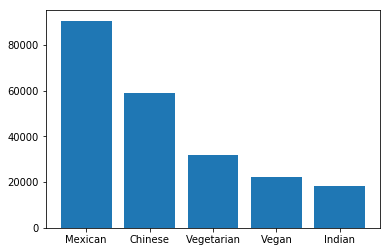

In [23]:
x = y_test.value_counts().values
lbls = list(y_test.value_counts().index)
plt.bar(range(len(x)), height=x, tick_label = lbls);

#### Train Set: Class Balance

In [24]:
y_train.value_counts()

Mexican       211298
Chinese       137954
Vegetarian     74127
Vegan          51280
Indian         42744
Name: category, dtype: int64

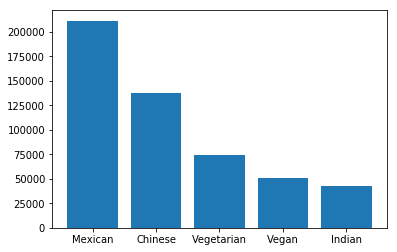

In [25]:
x = y_train.value_counts().values
lbls = list(y_train.value_counts().index)
plt.bar(range(len(x)), height=x, tick_label = lbls);

---

### Train data PREDICTION

In [26]:
pred2 = m_kmeans.predict(X_train_term_svd)

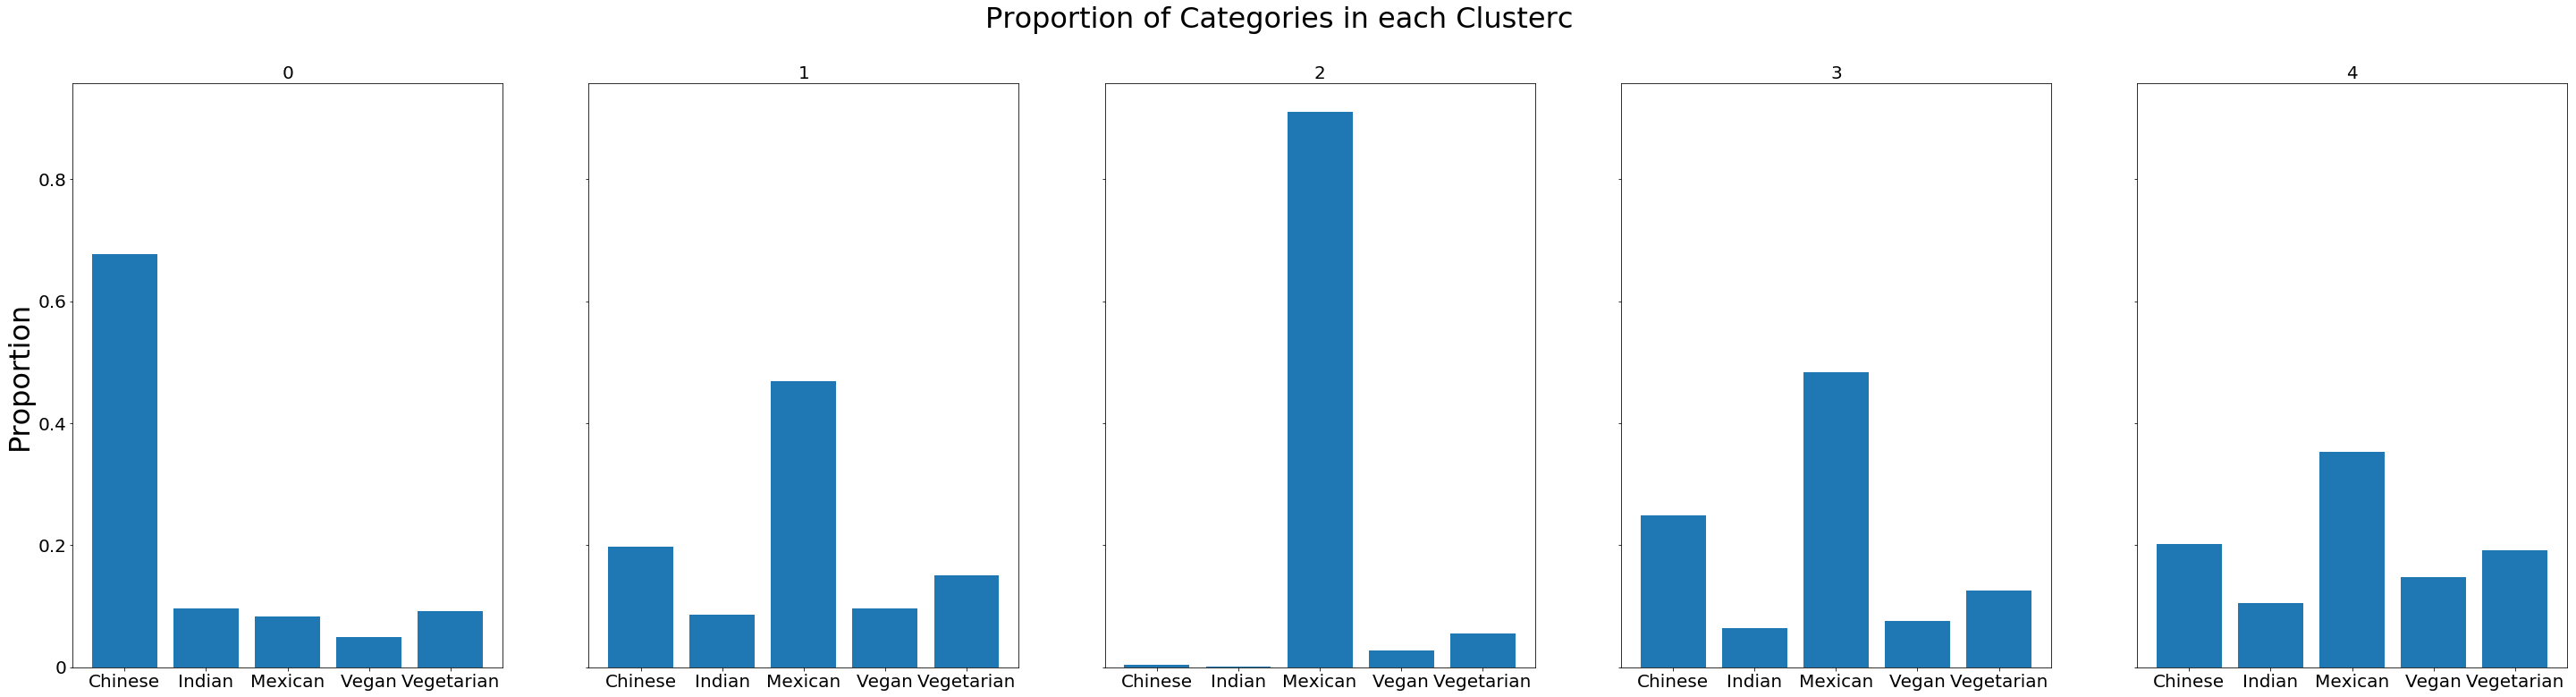

In [27]:
catPred(m_kmeans, y_train, pred2)

In [28]:
top_pred_words(m_kmeans, X_train_term, ftrs, pred2)


Cluster  0  =====
['im', 'sui', 'baos', 'foreigners', 'wooteep']
['couple', 'elbows', 'rubbing', 'soup', 'got']
['ohwell', 'amazing', 'pumpkin', 'rolls', 'kappa']
['rice', 'hard', 'cold', 'usual', 'hated']
['sooo', 'fatty', 'beef', 'soup', 'schewan']

Cluster  1  =====
['tucked', 'definite', 'indoor', 'oasis', 'barboaca']
['impressed', 'lamb', 'nan', 'timer', 'curry']
['return', 'thanks', 'san', 'diego', 'recommending']
['excellent', 'quick', 'sit', 'beat', 'flo']
['reasonable', 'surprised', 'nachos', 'downtown', 'recommend']

Cluster  2  =====
['surprised', 'mix', 'carnitas', 'tuna', 'agree']
['location', 'cent', 'awe', 'like', 'caramba']
['trip', 'returning', 'tacos', 'henderson', 'gusta']
['bacon', 'dish', 'seized', 'wrapped', 'cactus']
['oaxaca', 'condesa', 'baseball', 'multitudes', 'tacos']

Cluster  3  =====
['rid', '2013', 'room', 'poor', 'area']
['purposes', 'complainer', 'pay', 'serving', 'im']
['pass', 'using', 'qew', 'sushi', 'dump']
['undecided', 'headaches', 'buff', 'gril

# === === === === === === === === === === === === === === === 

In [29]:
# https://github.com/gSchool/dsi-solns-g69/blob/master/clustering/pair_part1_kmeans.py

In [30]:
pred

array([4, 3, 4, ..., 0, 3, 4], dtype=int32)

In [31]:
# Print out the reviews of a random sample of the restaurants assigned to each
# cluster to get a sense of the category.

print("\nRandom sample of reviews in each cluster")

assigned_cluster = m_kmeans.transform(X_train_term_svd)#.argmin(axis=1)


Random sample of reviews in each cluster


In [32]:
assigned_cluster

array([[0.17370167, 0.18132169, 0.22219916, 0.06313402, 0.10283767],
       [0.22245244, 0.2171537 , 0.125516  , 0.22619078, 0.19260694],
       [0.17877719, 0.1740362 , 0.22193939, 0.07458221, 0.10576846],
       ...,
       [0.27255721, 0.18399541, 0.28560781, 0.23375713, 0.19815293],
       [0.21845735, 0.31447897, 0.3226672 , 0.26157589, 0.25825591],
       [0.29057467, 0.24912698, 0.3149542 , 0.2661925 , 0.24128963]])

In [33]:
i = 1

assigned_cluster = m_kmeans.transform(X_train_term_svd)#.argmin(axis=1)

assigned_cluster = assigned_cluster[:10,:].argmin(axis=1)

assigned_cluster

array([3, 2, 3, 3, 4, 4, 4, 2, 4, 3])

In [68]:
pred2[:10]

array([3, 2, 3, 3, 4, 4, 4, 2, 4, 3], dtype=int32)

In [35]:
m_kmeans.cluster_centers_

array([[ 0.18228339, -0.07692559, -0.04838772,  0.06779744,  0.00767893,
         0.01091632, -0.018     , -0.01984398,  0.00185338,  0.00500899],
       [ 0.18857081,  0.11460932, -0.03383267,  0.00410074, -0.00445603,
         0.03475242, -0.00763856, -0.00889979, -0.01211165,  0.00153124],
       [ 0.18041927,  0.01580211,  0.14842673,  0.03129908,  0.01417226,
        -0.00342476, -0.01493756,  0.00080862,  0.04285377,  0.01111897],
       [ 0.17438382, -0.04084372,  0.00193105, -0.07978318, -0.01179172,
         0.00641159, -0.01008459,  0.00038248, -0.00527562,  0.0100825 ],
       [ 0.12161112,  0.00383308, -0.00714448, -0.00041162, -0.00714538,
        -0.02277857,  0.01963952,  0.01033667, -0.00295419, -0.01292969]])

---

### Top Words for Cluster Centroids

In [66]:
center_top_words(m_kmeans, m_svd, ftrs)

['chicken' 'rice' 'good' 'chinese' 'food' 'fried' 'soup' 'beef' 'ordered'
 'like'] 

['great' 'food' 'service' 'place' 'good' 'friendly' 'love' 'staff'
 'amazing' 'mexican'] 

['tacos' 'taco' 'good' 'salsa' 'best' 'place' 'asada' 'mexican' 'fish'
 'great'] 

['food' 'time' 'order' 'service' 'just' 'like' 'good' 'place' 'ordered'
 'got'] 

['food' 'place' 'good' 'love' 'delicious' 'really' 'like' 'restaurant'
 'friendly' 'staff'] 

